# Computer Vision Masterclass - Style Transfer

- Based on https://www.tensorflow.org/tutorials/generative/style_transfer?hl=en
- Style transfer paper: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

## Importing the libraries

In [1]:
!pip install tensorflow-gpu==2.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

## Loading the pre-trained convolutional neural network (VGG19)


<img src="https://github.com/csh970605/csh970605.github.io/assets/28240052/1f639688-5bb3-46a0-bb00-875be79cde2c" width=400>
<br>

+ The orange arrow : The output of original images.
+ The blue arrow : The output of style of images. That is, it indicates the style of images.

In [3]:
model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [4]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [5]:
len(model.layers)

22

## Loading and pre-processing the images

### Content image

In [6]:
content_image = tf.keras.preprocessing.image.load_img('chaves.jpeg')

(-0.5, 597.5, 447.5, -0.5)

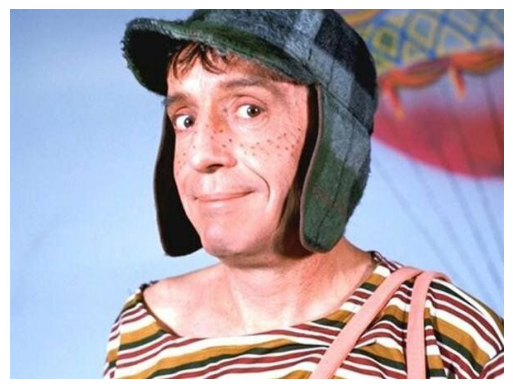

In [7]:
plt.imshow(content_image)
plt.axis('off')

In [8]:
type(content_image)

PIL.JpegImagePlugin.JpegImageFile

In [9]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

In [10]:
type(content_image), content_image.shape, content_image.min(), content_image.max()

(numpy.ndarray, (448, 598, 3), 0.0, 255.0)

In [11]:
content_image = content_image / content_image.max()
content_image = content_image[tf.newaxis, :]
content_image.shape, content_image.min(), content_image.max()

((1, 448, 598, 3), 0.0, 1.0)

### Style image

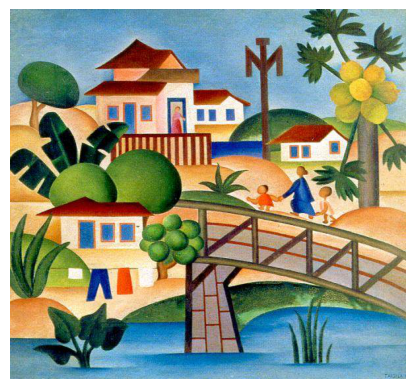

In [12]:
style_image = tf.keras.preprocessing.image.load_img('tarsila_amaral.jpg')
plt.imshow(style_image)
plt.axis('off')
style_image = tf.keras.preprocessing.image.img_to_array(style_image)

In [13]:
type(style_image), style_image.shape, style_image.min(), style_image.max()

(numpy.ndarray, (560, 600, 3), 0.0, 255.0)

In [14]:
style_image = style_image / style_image.max()
style_image = style_image[tf.newaxis, :]
style_image.shape, style_image.min(), style_image.max()

((1, 560, 600, 3), 0.0, 1.0)

## Building the neural network

In [15]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [16]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print(num_content_layers, num_style_layers)

1 5


In [17]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model(inputs=[vgg.input], outputs=outputs)

  return model

In [18]:
content_extractor = vgg_layers(content_layers)
content_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [19]:
content_extractor.outputs

[<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv2')>]

In [20]:
style_extractor = vgg_layers(style_layers)
style_extractor.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [21]:
style_extractor.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [22]:
content_extractor.outputs

[<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv2')>]

In [23]:
style_outputs = style_extractor(style_image)
content_outputs = content_extractor(content_image)
len(style_outputs), len(content_outputs)

(5, 1)

In [24]:
style_outputs[0]

<tf.Tensor: shape=(1, 560, 600, 64), dtype=float32, numpy=
array([[[[0.0000000e+00, 1.1168056e-01, 6.2121809e-02, ...,
          4.7374946e-01, 4.9520522e-01, 1.5619564e-01],
         [0.0000000e+00, 2.1199909e-01, 3.7911364e-01, ...,
          1.7614037e-01, 1.4901578e+00, 1.1453360e+00],
         [0.0000000e+00, 2.0160642e-01, 3.8564062e-01, ...,
          1.3608325e-01, 1.5308917e+00, 1.1796422e+00],
         ...,
         [0.0000000e+00, 3.3286181e-01, 5.1675826e-01, ...,
          0.0000000e+00, 1.6993666e+00, 1.3342988e+00],
         [0.0000000e+00, 3.4320116e-01, 5.2286661e-01, ...,
          0.0000000e+00, 1.7050551e+00, 1.3393183e+00],
         [7.8187567e-01, 4.2259818e-01, 7.7565944e-01, ...,
          4.4906515e-01, 2.4665630e+00, 2.3771269e+00]],

        [[0.0000000e+00, 1.1404040e-01, 0.0000000e+00, ...,
          7.9952955e-02, 0.0000000e+00, 0.0000000e+00],
         [6.3841367e-01, 2.4004281e-01, 3.5869697e-01, ...,
          0.0000000e+00, 5.8317912e-01, 7.0515585e-01

In [25]:
style_outputs[0].shape, style_outputs[1].shape, style_outputs[2].shape, style_outputs[3].shape, style_outputs[4].shape, content_outputs[0].shape

(TensorShape([1, 560, 600, 64]),
 TensorShape([1, 280, 300, 128]),
 TensorShape([1, 140, 150, 256]),
 TensorShape([1, 70, 75, 512]),
 TensorShape([1, 35, 37, 512]),
 TensorShape([56, 74, 512]))

In [26]:
# https://www.tensorflow.org/api_docs/python/tf/einsum

# Loss between the style and the content image
def gram_matrix(layer_activation):
  result = tf.linalg.einsum('bijc,bijd->bcd', layer_activation, layer_activation)
  input_shape = tf.shape(layer_activation)
  # Get the shape of image
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

  return result / num_locations

In [27]:
style_outputs[0].shape, gram_matrix(style_outputs[0]).shape

(TensorShape([1, 560, 600, 64]), TensorShape([1, 64, 64]))

In [28]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super().__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs = outputs[ : self.num_style_layers]
    content_outputs = outputs[self.num_style_layers : ]

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content' : content_dict, 'style' : style_dict}

In [29]:
extractor = StyleContentModel(style_layers, content_layers)

In [30]:
results = extractor.call(content_image)

In [31]:
results

{'content': {'block4_conv2': <tf.Tensor: shape=(1, 56, 74, 512), dtype=float32, numpy=
  array([[[[  17.105906,    0.      ,    0.      , ...,  574.59753 ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  291.4188  ,
             132.35075 ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  332.0522  ,
             118.95296 ,    0.      ],
           ...,
           [ 700.1252  ,    0.      ,    0.      , ..., 1511.4626  ,
              11.20654 ,  325.48343 ],
           [ 141.8678  ,    0.      ,    0.      , ..., 1099.7535  ,
              96.57425 ,  195.72565 ],
           [ 137.43658 ,    0.      ,    0.      , ...,  469.20248 ,
             180.22122 ,  676.2001  ]],
  
          [[   0.      ,    0.      ,    0.      , ...,  549.1022  ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,   44.160194,
               0.      ,    0.      ],
           [   0.      ,    0

In [32]:
for key, value in results.items():
  print(key, value.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [33]:
style_targets = extractor.call(style_image)['style']
content_targets = extractor.call(content_image)['content']

In [34]:
style_targets.keys(), content_targets.keys()

(dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']),
 dict_keys(['block4_conv2']))

In [35]:
new_image = tf.Variable(content_image)

In [36]:
content_weights = 1
style_weights = 1000
optimizer = tf.optimizers.Adam(learning_rate=0.02)

## Training

In [37]:
epochs = 5000
print_every = 500

for epoch in range(epochs):
  # define what will be the next value of pixels.
  with tf.GradientTape() as tape:
    outputs = extractor(new_image)

    content_outputs = outputs['content']
    style_outputs = outputs['style']

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])

    total_loss = content_loss * content_weights / num_content_layers + style_loss * style_weights / num_style_layers
  
  gradient = tape.gradient(total_loss, new_image)
  optimizer.apply_gradients([(gradient, new_image)])

  new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

  if (epochs + 1) % print_every == 0:
    print('Epoch {} | content loss: {} | style loss : {} | total loss{}'.format(epoch + 1, content_loss, style_loss, total_loss))
    plt.imshow(tf.squeenze(new_image, axis=0))
    plt.axis('off')
    plt.show()


## Visualizing the results

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
ax1.imshow(tf.squeeze(content_image, axis=0))
ax1.set_title('Content image')
ax1.axis('off')

ax2.imshow(tf.squeeze(new_image, axis=0))
ax2.set_title('New image')
ax2.axis('off')

ax3.imshow(tf.squeeze(style_image, axis=0))
ax3.set_title('Style image')
ax3.axis('off')

plt.show()


Output hidden; open in https://colab.research.google.com to view.